In [84]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

dataset = Planetoid(root='/tmp/cora', name='Cora')
loader = DataLoader(dataset, batch_size=1, shuffle=True)
for batch in loader:
    print(batch)

DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


Processing...
Done!


In [85]:
dataset = Planetoid(root='/tmp/cora', name='Cora')
loader = DataLoader(dataset, batch_size=1, shuffle=True)
for batch in loader:
    print(batch)

DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


In [86]:
print(len(batch.x[0]))
batch.edge_index

1433


tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [87]:
x_dom=batch.x
print(x_dom)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [88]:
print(batch.train_mask)
print(np.sum(batch.train_mask.numpy()))

tensor([ True,  True,  True,  ..., False, False, False])
140


In [89]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [90]:
#implementing GCN network
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(num_features, 42)
        self.conv2 = GCNConv(42, 42)
        self.conv3 = GCNConv(42, 42)
        self.classifier = Linear(42, 7) #7 class, 2 input

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h



In [105]:
def train(x, edge_index, train_mask,test_mask,y):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(x, edge_index)  # Perform a single forward pass.
    loss = criterion(out[train_mask], y[train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = y[train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the test node
    predicted_classes = torch.argmax(out[test_mask], axis=1)
    target_classes = y[test_mask]
    accuracy['test'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

In [92]:
import pandas as pd
import numpy as np

df_data = pd.read_csv('Feature_cora.csv')

df_data.head(10)

,Unnamed: 0,a_0,b_0,a_1,b_1,a_2,b_2,a_3,b_3,a_4,...,S_5,S_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6,Class
0,0,1,0,155,3,5,0,0,0,4,...,2,1,16,20,20,16,17,12,14,1
1,1,0,0,3,1,0,0,0,0,0,...,7,4,16,18,18,17,15,16,15,1
2,2,0,0,0,0,1,0,1,0,40,...,3,1,10,11,12,10,12,7,8,4
3,3,0,0,0,0,0,0,3,0,14,...,2,5,13,17,19,18,20,14,18,4
4,4,0,0,0,0,0,1,0,0,4,...,2,3,17,17,19,17,20,15,17,4
5,5,0,0,0,0,0,0,0,1,3,...,3,5,20,21,22,19,22,16,21,4
6,6,0,0,0,0,0,0,0,0,0,...,1,4,16,16,19,18,15,17,19,6
7,7,0,0,0,0,1,0,0,0,1,...,5,5,18,21,21,17,21,15,19,4
8,8,2,0,0,0,1,1,0,1,0,...,4,3,17,14,17,17,13,18,14,5
9,9,0,0,0,0,1,0,0,0,0,...,3,4,19,22,22,20,22,17,20,4


In [93]:
data_c=df_data.drop(['Unnamed: 0','Class'], axis=1)
data_c.head()

,a_0,b_0,a_1,b_1,a_2,b_2,a_3,b_3,a_4,b_4,...,S_4,S_5,S_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6
0,1,0,155,3,5,0,0,0,4,0,...,3,2,1,16,20,20,16,17,12,14
1,0,0,3,1,0,0,0,0,0,0,...,6,7,4,16,18,18,17,15,16,15
2,0,0,0,0,1,0,1,0,40,0,...,4,3,1,10,11,12,10,12,7,8
3,0,0,0,0,0,0,3,0,14,0,...,8,2,5,13,17,19,18,20,14,18
4,0,0,0,0,0,1,0,0,4,3,...,8,2,3,17,17,19,17,20,15,17


In [94]:
De=data_c.to_numpy()
Fe=np.array(De,dtype="f")

In [95]:
import numpy as np

p_data = open("/Users/joshem/PhD Research/Data/cora/cora.cites")


# Create a list from the data
myls=list(p_data)

# Remove the new line symbole from the list
mylist = [line.rstrip('\n') for line in myls]
#print(mylist)
#print(graph_ind)
#print(graph_level)

p_data.close()

In [96]:
mynode=[]
Edgelist=[]
i=0
for d in mylist:
    d=mylist[i].split("\t")
    mynode.append(int(d[0]))
    mynode.append(int(d[1]))
    Edgelist.append([int(d[0]),int(d[1])])
    i=i+1
#print(mynode)
node_ID1=np.unique(mynode)
node_ID=list(node_ID1)
#print(node_ID)
n=len(node_ID)
print(n)

2708


In [97]:

edgelist=[]
i=0
for d in mylist:
    d=mylist[i].split("\t")
    edgelist.append([node_ID.index(int(d[0])),node_ID.index(int(d[1]))])
    i=i+1
#print(edgelist)

In [98]:
train=[True, False, True, True, False, False, False, False, False, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, False, False, False, False, True, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, False, False, False, False, True, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, True, False, False, True, False, True, True, True, False, False, False, True, False, True, True, False, True, True, True, True, False, False, True, True, True, True, True, True, False, True, True, False, True, True, False, True, True, True, False, False, True, False, False, False, False, True, True, True, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, True, True, True, True, False, True, True, False, False, True, True, False, False, False, False, True, True, True, False, False, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, False, True, True, True, False, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, True, False, True, False, True, True, True, True, False, False, True, True, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, False, False, True, True, False, False, True, False, True, True, False, False, True, True, False, True, True, True, True, False, False, True, False, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, True, False, True, True, True, True, True, False, True, False, False, True, False, False, False, True, False, True, False, False, True, False, False, True, True, True, False, False, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, False, False, False, False, False, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, False, True, False, True, True, True, True, False, True, False, True, False, False, False, False, True, False, False, True, False, True, False, True, True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, True, True, True, False, False, True, True, True, False, True, False, True, False, False, True, False, True, True, True, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, False, False, True, True, True, True, False, True, False, False, True, False, True, True, True, False, True, True, True, False, True, False, False, True, True, False, True, True, True, False, True, True, True, True, False, True, False, False, True, False, True, False, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, False, True, False, True, False, False, True, True, False, True, True, False, True, True, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, True, False, True, True, False, True, True, False, True, True, False, False, True, True, False, True, False, True, True, False, False, True, False, True, True, True, True, False, False, True, False, False, False, True, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, False, True, False, False, True, False, True, False, True, False, True, True, True, True, False, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, False, True, True, False, False, True, True, True, False, True, False, True, False, True, True, False, True, True, False, False, False, True, False, True, True, True, True, False, False, True, True, True, True, False, True, True, False, True, True, True, False, False, True, True, True, False, True, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, False, True, False, True, False, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, False, False, False, True, True, True, False, False, False, True, True, False, True, True, False, True, False, True, True, True, False, False, False, False, False, True, False, True, True, True, True, True, False, True, True, True, False, False, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, False, False, True, True, True, False, True, True, False, True, False, True, False, False, True, True, False, False, True, False, True, True, False, False, True, True, True, False, False, True, True, True, True, False, True, True, True, True, True, True, False, False, True, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False, False, True, False, True, False, False, False, True, True, False, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, False, True, True, True, False, False, True, True, True, True, True, False, True, True, True, False, True, False, True, False, True, False, True, True, True, False, True, False, True, False, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, False, True, False, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, False, True, True, True, True, False, True, True, True, True, False, True, True, True, False, False, False, False, True, False, False, True, False, True, True, False, False, True, False, True, True, True, True, False, True, True, False, True, True, True, False, False, True, False, False, False, True, True, True, True, True, True, False, True, True, True, True, False, False, False, False, True, True, True, False, True, True, True, False, True, False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, False, True, False, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, False, True, True, False, True, False, True, False, True, False, True, True, False, True, True, False, True, False, False, True, False, False, False, True, True, False, False, True, True, True, False, True, True, False, False, True, True, False, False, True, True, True, True, True, True, True, True, False, True, False, True, False, False, False, True, False, False, False, True, True, False, True, False, False, True, False, True, False, False, True, True, False, True, False, False, False, True, False, False, True, True, False, True, False, False, True, False, True, False, False, False, True, False, False, True, True, False, False, True, False, True, True, True, True, True, False, True, True, False, True, False, False, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, False, False, False, True, True, False, True, True, True, False, True, False, False, True, True, False, False, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, True, False, True, False, False, False, True, True, False, True, False, False, True, False, True, False, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, True, False, True, False, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, False, False, False, True, True, False, True, True, True, True, True, False, True, True, True, True, False, False, True, False, True, True, False, False, False, True, False, True, True, False, True, True, True, True, False, True, False, False, True, True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, True, False, True, False, True, False, False, False, False, True, False, True, True, True, False, False, False, False, True, True, False, True, False, False, True, True, True, False, True, False, True, True, True, True, False, True, False, False, True, True, True, True, False, False, False, True, True, True, False, True, False, True, True, False, False, False, True, False, True, False, True, True, True, False, False, False, True, False, False, False, True, False, True, True, False, False, True, True, False, True, False, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, True, False, False, False, True, False, True, True, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, False, True, False, False, True, False, False, True, False, True, False, False, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, False, False, True, True, True, False, True, True, False, True, True, True, True, False, False, False, False, False, False, True, False, False, True, False, True, False, False, True, True, False, True, True, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, True, False, True, True, False, True, True, False, False, True, False, False, True, False, True, True, True, True, False, True, True, True, True, True, True, True, False, False, True, False, False, True, True, False, True, True, False, True, True, False, True, True, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, False, True, False, False, False, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, False, True, True, False, True, False, False, False, False, True, True, True, True, True, True, True, False, True, True, False, True, True, False, False, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, False, False, True, False, True, True, False, True, True, True, True, True, False, False, True, False, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, False, False, False, True, True, False, False, False, True, True, False, True, False, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, False, True, False, False, False, True, True, True, True, False, False, True, True, True, False, False, True, False, True, True, False, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, False, True, False, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, False, False, True, True, False, False, False, True, False, False, True, False, False, True, True, False, False, False, True, True, True, False, True, True, False, True, True, True, True, True, True, False, False, False, True, False, True, True, True, False, False, True, True, False, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, False, True, True, False, True, True, False, False, False, False, True, True, False, False, True, True, False, True, True, False, True, True, True, True, True, True, True, False, True, True, True, False, False, False, True, True, False, True, False, False, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, False, False, True, True, False, True, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, False, False, False, False, True, False, True, True, True, False, True, False, False, False, True, False, True, False, True, False, True, False, True, False, True, False, False, False, False, True, False, True, True, False, False, True, False, True, False, True, True, True, False, True, True, False, True, True, True, True, False, True, True, True, True, False, False, True, False, False, True, True, False, False, True, False, False, True, False, True, True, True, True, False, True, True, False, False, False, False, True, False, False, True, False, True, False, True, True, True, True, False, True, True, True, True, True, False, True, False, True, False, True, False, True, True, False, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, False, True, False, True, False, False, True, False, True, False, False, True, True, False, True, True, False, False, True, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, True, True, False, True, True, False, True, False, False, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, False, True, False, True, True, True, True, True, True, False, False, True, True, False, True, True, False, False, True, False, True, True, True, False, True, True, False, True, True, False, False, True, True, True, True, False, False, False, False, True, False, False, True, False, False, True, True, False, False, True, True, False, False, True, True, False, False, True, True, False, True, False, False, True, True, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, False, True, False, True, True, False, False, True, True, True, True, True, False, False, True, False, True, False, True, True, True, False, True, True, True, False, True, True, True, False, False, False, False, True, False, True, True, False, False, True, True]

In [99]:
test=[]
for j in range(2708):
    if train[j]==True:
        test.append(False)
    else:
        test.append(True)
        j=j+1
        
#print(test)

In [100]:
#val_mask need to be updated
import torch
edgelist=np.array(edgelist)
x = torch.from_numpy(Fe)
edge_index=torch.from_numpy(edgelist)
Class=df_data['Class'].to_numpy()
y=torch.from_numpy(Class)
train_mask=torch.from_numpy(np.array(train))
test_mask=torch.from_numpy(np.array(test))
val_mask=torch.from_numpy(np.array(test))
print(x)

tensor([[  1.,   0., 155.,  ...,  17.,  12.,  14.],
        [  0.,   0.,   3.,  ...,  15.,  16.,  15.],
        [  0.,   0.,   0.,  ...,  12.,   7.,   8.],
        ...,
        [  0.,   0.,   0.,  ...,  15.,  20.,  15.],
        [  0.,   0.,   0.,  ...,  13.,  19.,  12.],
        [  0.,   0.,   0.,  ...,  13.,  18.,  17.]])


In [101]:
import torch
from torch_geometric.data import Data
dataset = Data(x=x, edge_index=edge_index.t().contiguous(),y=y,train_mask=train_mask,test_mask=test_mask,val_mask=val_mask,name='Cora', num_classes=7)

In [102]:
test_loader = loader = DataLoader([dataset], batch_size=1, shuffle=True)
for batch in loader:
    print(batch)

DataBatch(x=[2708, 42], edge_index=[2, 5429], y=[2708], train_mask=[2708], test_mask=[2708], val_mask=[2708], name=[1], num_classes=[1], batch=[2708], ptr=[2])


/Users/joshem/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [103]:
print(batch.x)

tensor([[  1.,   0., 155.,  ...,  17.,  12.,  14.],
        [  0.,   0.,   3.,  ...,  15.,  16.,  15.],
        [  0.,   0.,   0.,  ...,  12.,   7.,   8.],
        ...,
        [  0.,   0.,   0.,  ...,  15.,  20.,  15.],
        [  0.,   0.,   0.,  ...,  13.,  19.,  12.],
        [  0.,   0.,   0.,  ...,  13.,  18.,  17.]])


In [155]:
import time
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(len(batch.x[0]))
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.
CC=[]
for epoch in range(50):
    loss, h, accuracy = train(batch.x, batch.edge_index,batch.train_mask,batch.test_mask,batch.y)
    CC.append(accuracy["test"])
    # Visualize the node embeddings every 10 epochs
    if epoch % 1 == 0:
        #visualize(h, color=y, epoch=epoch, loss=loss, accuracy=accuracy)
        #time.sleep(0.3)
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f},Training Accuracy: {accuracy["train"]*100:.2f}% Validation Accuracy: {accuracy["val"]*100:.2f}%,Test Accuracy: {accuracy["test"]*100:.2f}%')
print("Maximum accuracy: {0}".format(max(CC)))
#print("Minimum loss: {0}".format(min(losses)))

Epoch: 0, Loss: 1.9448,Training Accuracy: 7.08% Validation Accuracy: 7.13%,Test Accuracy: 7.20%
Epoch: 1, Loss: 1.6782,Training Accuracy: 37.59% Validation Accuracy: 37.37%,Test Accuracy: 37.00%
Epoch: 2, Loss: 1.5343,Training Accuracy: 45.84% Validation Accuracy: 45.90%,Test Accuracy: 46.00%
Epoch: 3, Loss: 1.3892,Training Accuracy: 57.67% Validation Accuracy: 57.31%,Test Accuracy: 56.70%
Epoch: 4, Loss: 1.2331,Training Accuracy: 64.99% Validation Accuracy: 64.51%,Test Accuracy: 63.70%
Epoch: 5, Loss: 1.0800,Training Accuracy: 69.09% Validation Accuracy: 69.02%,Test Accuracy: 68.90%
Epoch: 6, Loss: 0.9424,Training Accuracy: 73.19% Validation Accuracy: 72.38%,Test Accuracy: 71.00%
Epoch: 7, Loss: 0.8443,Training Accuracy: 77.63% Validation Accuracy: 76.77%,Test Accuracy: 75.30%
Epoch: 8, Loss: 0.7494,Training Accuracy: 77.75% Validation Accuracy: 77.18%,Test Accuracy: 76.20%
Epoch: 9, Loss: 0.6919,Training Accuracy: 78.92% Validation Accuracy: 78.69%,Test Accuracy: 78.30%
Epoch: 10, Lo

In [151]:
import time
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(len(x_dom[0]))
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.
gcn=[]
for epoch in range(50):
    loss, h, accuracy = train(x_dom, batch.edge_index,batch.train_mask,batch.test_mask,batch.y)
    gcn.append(accuracy["test"])
    # Visualize the node embeddings every 10 epochs
    if epoch % 1 == 0:
        #visualize(h, color=y, epoch=epoch, loss=loss, accuracy=accuracy)
        #time.sleep(0.3)
        print(f'Epoch: {epoch}, Loss: {loss.item():.4f},Training Accuracy: {accuracy["train"]*100:.2f}% Validation Accuracy: {accuracy["val"]*100:.2f}%,Test Accuracy: {accuracy["test"]*100:.2f}%')
print("Maximum accuracy: {0}".format(max(gcn)))

Epoch: 0, Loss: 1.9708,Training Accuracy: 14.23% Validation Accuracy: 14.36%,Test Accuracy: 14.60%
Epoch: 1, Loss: 1.7752,Training Accuracy: 34.02% Validation Accuracy: 33.71%,Test Accuracy: 33.20%
Epoch: 2, Loss: 1.6245,Training Accuracy: 37.47% Validation Accuracy: 36.82%,Test Accuracy: 35.70%
Epoch: 3, Loss: 1.4501,Training Accuracy: 49.47% Validation Accuracy: 48.71%,Test Accuracy: 47.40%
Epoch: 4, Loss: 1.2427,Training Accuracy: 67.92% Validation Accuracy: 65.66%,Test Accuracy: 61.80%
Epoch: 5, Loss: 1.0445,Training Accuracy: 76.52% Validation Accuracy: 73.63%,Test Accuracy: 68.70%
Epoch: 6, Loss: 0.8727,Training Accuracy: 79.80% Validation Accuracy: 76.85%,Test Accuracy: 71.80%
Epoch: 7, Loss: 0.7332,Training Accuracy: 81.91% Validation Accuracy: 78.66%,Test Accuracy: 73.10%
Epoch: 8, Loss: 0.6147,Training Accuracy: 84.02% Validation Accuracy: 80.91%,Test Accuracy: 75.60%
Epoch: 9, Loss: 0.5220,Training Accuracy: 85.30% Validation Accuracy: 81.87%,Test Accuracy: 76.00%
Epoch: 10,

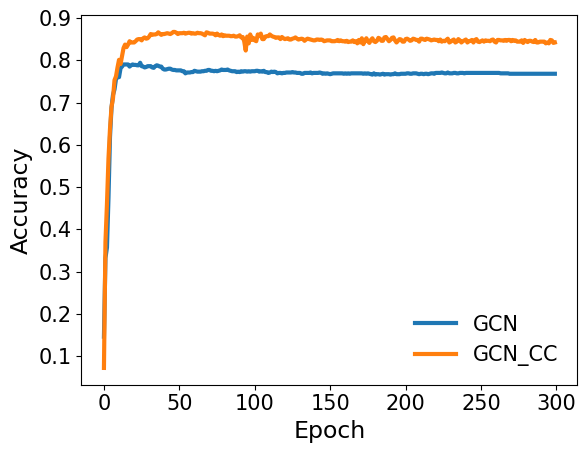

In [147]:
plt.plot(gcn,linewidth=3,label='GCN')
plt.plot(CC,linewidth=3,label='GCN_CC')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend()
plt.xlabel("Epoch",fontsize = 17)
plt.ylabel("Accuracy",fontsize = 17)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.ylim(0,1)
#plt.legend(["blue", "green"], loc="lower right")
plt.legend(loc="lower right",frameon=False,fontsize = 15)
#for pos in ['right', 'top']: 
    #plt.gca().spines[pos].set_visible(False)
#plt.savefig("CC_GCN.pdf")
plt.show
plt.savefig("CC_GCN.pdf",bbox_inches="tight")